# Naive Bayes

In [63]:
import csv
import random

In [40]:
def carregar(arquivo, delimiter=';', header=True):
    data = []
    with open(arquivo) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=delimiter)
        if header:
            count = 0
        else:
            count = 1
        for row in csv_reader:
            if count != 0 :
                if row:
                    data.append(tuple(row))
            count += 1
    return(data)

In [3]:
def treinamento(data):
    total = len(data)
    classes = list(set([x[-1] for x in data]))
    combdata = {}
    pdata = {}
    for row in data:
        classe = (row[-1])
        if classe in combdata:
            combdata[classe] += 1
        else:
            combdata[classe] = 1    
        for i, d in enumerate(row[:-1]):
            # variavel continua
            if d.replace('.','',1).isdigit():
                ind = 'i'+str(i)
                if ind in combdata:
                    combdata[ind].append(float(d))
                else:
                    combdata[ind] = [ float(d) ]
                key = (ind,classe)    
                if key in combdata:
                    combdata[key].append(float(d))
                else:
                    combdata[key] = [float(d)]
            # variavel nominal
            else:
                if d in combdata:
                    combdata[d] += 1
                else:
                    combdata[d] = 1
                key = (d,classe)
                if key in combdata:
                    combdata[key] += 1
                else:
                    combdata[key] = 1
    # calculando probabilidades
    probdata = {}
    for c in combdata:
        if type(c) == tuple:
            if type(combdata[c]) != list:
                probdata[c] = combdata[c] / combdata[c[1]]
            else:
                media =  sum(combdata[c])/len(combdata[c])
                desvio = (sum([(x-media)**2 for x in combdata[c]])/(len(combdata[c])-1))**0.5
                probdata[c] = {
                    'media' : media,
                    'desvio' : desvio
                }
        else:
            if type(combdata[c]) != list:
                probdata[c] = combdata[c] / total
            else:
                media =  sum(combdata[c])/len(combdata[c])
                desvio = (sum([(x-media)**2 for x in combdata[c]])/(len(combdata[c])-1))**0.5
                probdata[c] = {
                    'media' : media,
                    'desvio' : desvio
                }
    probdata['classes'] = classes
    return(probdata)

In [4]:
def g(x, media, desvio):
    p1 = 1 / ( (2*3.141592653589793)**0.5 * desvio  )
    p2 = 2.718281828459045 ** (-((x - media) ** 2) / (2 * desvio ** 2))
    return p1 * p2

# testando função g
print(g(83, 73.00, 6.16)) # 0.017
print(g(83, 74.60, 7.89)) # 0.029
print(g(83, 73.57, 6.57)) # 0.022

0.017340835222313836
0.028688396603888434
0.021676800985283348


In [157]:
def verificar(probdata, tupla, debug=False):
    probClasse = {}
    valClasse = 0
    maxClasse = ''
    for classe in probdata['classes']:
        numerador = 1
        denominador = 1
        i=0
        for v in tupla:
            #if type(v) == str:
            if not v.replace('.','',1).isdigit():
                key = (v, classe)
                if key in probdata:
                    numerador = numerador * probdata[key]
                else:
                    numerador = numerador * 0.001
                #if v in probdata:
                #    denominador = denominador * probdata[v]
                #else:
                denominador = denominador * 0.001
            else:
                v = float(v)
                key1 = ('i'+str(i),classe)
                key2 = 'i'+str(i)
                i += 1
                if key1 in probdata:
                    numerador = numerador * g(v,probdata[key1]['media'],probdata[key1]['desvio'])
                #else:
                #    numerador = numerador * 0.001
                denominador = denominador * g(v,probdata[key2]['media'],probdata[key2]['desvio'])
        numerador = numerador * probdata[classe]
        probClasse[classe] = numerador / denominador
        if debug:
            print(classe,probClasse[classe])
        if probClasse[classe] > valClasse:
            valClasse = probClasse[classe]
            maxClasse = classe
    return(maxClasse)

# dataset tempo

In [6]:
tempo =  carregar('data/tempo.csv')
tempo

[('sunny', 'no'),
 ('overcast', 'yes'),
 ('rainny', 'yes'),
 ('sunny', 'yes'),
 ('sunny', 'yes'),
 ('overcast', 'yes'),
 ('rainny', 'no'),
 ('rainny', 'no'),
 ('sunny', 'yes'),
 ('rainny', 'yes'),
 ('sunny', 'no'),
 ('overcast', 'yes'),
 ('overcast', 'yes'),
 ('rainny', 'no')]

In [7]:
modeloTempo = treinamento(tempo)

In [26]:
modeloTempo

{'no': 0.35714285714285715,
 'sunny': 0.35714285714285715,
 ('sunny', 'no'): 0.4,
 'yes': 0.6428571428571429,
 'overcast': 0.2857142857142857,
 ('overcast', 'yes'): 0.4444444444444444,
 'rainny': 0.35714285714285715,
 ('rainny', 'yes'): 0.2222222222222222,
 ('sunny', 'yes'): 0.3333333333333333,
 ('rainny', 'no'): 0.6,
 'classes': ['yes', 'no']}

In [9]:
verificar(modeloTempo, ['sunny'], debug=True)

yes 0.6
no 0.4


'yes'

In [10]:
verificar(modeloTempo, ['overcast'], debug=True)

yes 1.0
no 0.00125


'yes'

In [11]:
verificar(modeloTempo, ['rainny'], debug=True)

yes 0.39999999999999997
no 0.6


'no'

# dataset tenis

In [12]:
tenis = carregar('data/tenis.csv')
tenis

[('sol', 'quente', 'alta', 'falso', 'não'),
 ('sol', 'quente', 'alta', 'verdadeiro', 'não'),
 ('nublado', 'quente', 'alta', 'falso', 'sim'),
 ('chuva', 'agradável', 'alta', 'falso', 'sim'),
 ('chuva', 'fria', 'normal', 'falso', 'sim'),
 ('chuva', 'fria', 'normal', 'verdadeiro', 'não'),
 ('nublado', 'fria', 'normal', 'verdadeiro', 'sim'),
 ('sol', 'agradável', 'alta', 'falso', 'não'),
 ('sol', 'fria', 'normal', 'falso', 'sim'),
 ('chuva', 'agradável', 'normal', 'falso', 'sim'),
 ('sol', 'agradável', 'normal', 'verdadeiro', 'sim'),
 ('nublado', 'agradável', 'alta', 'verdadeiro', 'sim'),
 ('nublado', 'quente', 'normal', 'falso', 'sim'),
 ('chuva', 'agradável', 'alta', 'verdadeiro', 'não')]

In [13]:
modeloTenis = treinamento(tenis)

In [25]:
modeloTenis

{'não': 0.35714285714285715,
 'sol': 0.35714285714285715,
 ('sol', 'não'): 0.6,
 'quente': 0.2857142857142857,
 ('quente', 'não'): 0.4,
 'alta': 0.5,
 ('alta', 'não'): 0.8,
 'falso': 0.5714285714285714,
 ('falso', 'não'): 0.4,
 'verdadeiro': 0.42857142857142855,
 ('verdadeiro', 'não'): 0.6,
 'sim': 0.6428571428571429,
 'nublado': 0.2857142857142857,
 ('nublado', 'sim'): 0.4444444444444444,
 ('quente', 'sim'): 0.2222222222222222,
 ('alta', 'sim'): 0.3333333333333333,
 ('falso', 'sim'): 0.6666666666666666,
 'chuva': 0.35714285714285715,
 ('chuva', 'sim'): 0.3333333333333333,
 'agradável': 0.42857142857142855,
 ('agradável', 'sim'): 0.4444444444444444,
 'fria': 0.2857142857142857,
 ('fria', 'sim'): 0.3333333333333333,
 'normal': 0.5,
 ('normal', 'sim'): 0.6666666666666666,
 ('chuva', 'não'): 0.4,
 ('fria', 'não'): 0.2,
 ('normal', 'não'): 0.2,
 ('verdadeiro', 'sim'): 0.3333333333333333,
 ('agradável', 'não'): 0.4,
 ('sol', 'sim'): 0.2222222222222222,
 'classes': ['não', 'sim']}

In [16]:
tupla = ('sol', 'fria', 'alta', 'verdadeiro')
print(verificar(modeloTenis, tupla, debug=True))

não 0.9408
sim 0.2419753086419753
não


In [17]:
tupla = ('chuva', 'fria', 'normal', 'verdadeiro')
print(verificar(modeloTenis, tupla, debug=True))

não 0.15680000000000005
sim 0.7259259259259259
sim


# tenis2 dataset: atributos continuos

In [33]:
tenis2 = carregar('data/tenis2.csv')
tenis2

[('sol', '85.01', '85', 'falso', 'não'),
 ('sol', '80', '90', 'verdadeiro', 'não'),
 ('nublado', '83', '86', 'falso', 'sim'),
 ('chuva', '70', '96', 'falso', 'sim'),
 ('chuva', '68', '80', 'falso', 'sim'),
 ('chuva', '65', '70', 'verdadeiro', 'não'),
 ('nublado', '64', '65', 'verdadeiro', 'sim'),
 ('sol', '72', '95', 'falso', 'não'),
 ('sol', '69', '70', 'falso', 'sim'),
 ('chuva', '75', '80', 'falso', 'sim'),
 ('sol', '75', '70', 'verdadeiro', 'sim'),
 ('nublado', '72', '90', 'verdadeiro', 'sim'),
 ('nublado', '81', '75', 'falso', 'sim'),
 ('chuva', '71', '91', 'verdadeiro', 'não')]

In [94]:
lista = [1.55, 1.70, 1.80]
media =  sum(lista)/len(lista)
desvio = (sum([(x-media)**2 for x in lista])/len(lista))**0.5
print(media,' ',desvio)


1.6833333333333333   0.10274023338281627


In [20]:
modeloTenis2 = treinamento(tenis2)

In [21]:
modeloTenis2

{'não': 0.35714285714285715,
 'sol': 0.35714285714285715,
 ('sol', 'não'): 0.6,
 'i1': {'media': 73.57214285714285, 'desvio': 6.573005609860131},
 ('i1', 'não'): {'media': 74.602, 'desvio': 7.896329527065093},
 'i2': {'media': 81.64285714285714, 'desvio': 10.285218242007035},
 ('i2', 'não'): {'media': 86.2, 'desvio': 9.731392500562292},
 'falso': 0.5714285714285714,
 ('falso', 'não'): 0.4,
 'verdadeiro': 0.42857142857142855,
 ('verdadeiro', 'não'): 0.6,
 'sim': 0.6428571428571429,
 'nublado': 0.2857142857142857,
 ('nublado', 'sim'): 0.4444444444444444,
 ('i1', 'sim'): {'media': 73.0, 'desvio': 6.164414002968976},
 ('i2', 'sim'): {'media': 79.11111111111111, 'desvio': 10.215728613814635},
 ('falso', 'sim'): 0.6666666666666666,
 'chuva': 0.35714285714285715,
 ('chuva', 'sim'): 0.3333333333333333,
 ('chuva', 'não'): 0.4,
 ('verdadeiro', 'sim'): 0.3333333333333333,
 ('sol', 'sim'): 0.2222222222222222,
 'classes': ['não', 'sim']}

In [24]:
tupla = ('sol', 83, 73, 'verdadeiro')
print(verificar(modeloTenis2, tupla, debug=True))

não 0.6661640966995964
sim 0.29830336029759913
não


# dataset iris

In [27]:
!head data/iris/iris.data

5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa


In [152]:
iris = carregar("data/iris/iris.data", delimiter=',', header=False)

In [153]:
iris

[('5.1', '3.5', '1.4', '0.2', 'Iris-setosa'),
 ('4.9', '3.0', '1.4', '0.2', 'Iris-setosa'),
 ('4.7', '3.2', '1.3', '0.2', 'Iris-setosa'),
 ('4.6', '3.1', '1.5', '0.2', 'Iris-setosa'),
 ('5.0', '3.6', '1.4', '0.2', 'Iris-setosa'),
 ('5.4', '3.9', '1.7', '0.4', 'Iris-setosa'),
 ('4.6', '3.4', '1.4', '0.3', 'Iris-setosa'),
 ('5.0', '3.4', '1.5', '0.2', 'Iris-setosa'),
 ('4.4', '2.9', '1.4', '0.2', 'Iris-setosa'),
 ('4.9', '3.1', '1.5', '0.1', 'Iris-setosa'),
 ('5.4', '3.7', '1.5', '0.2', 'Iris-setosa'),
 ('4.8', '3.4', '1.6', '0.2', 'Iris-setosa'),
 ('4.8', '3.0', '1.4', '0.1', 'Iris-setosa'),
 ('4.3', '3.0', '1.1', '0.1', 'Iris-setosa'),
 ('5.8', '4.0', '1.2', '0.2', 'Iris-setosa'),
 ('5.7', '4.4', '1.5', '0.4', 'Iris-setosa'),
 ('5.4', '3.9', '1.3', '0.4', 'Iris-setosa'),
 ('5.1', '3.5', '1.4', '0.3', 'Iris-setosa'),
 ('5.7', '3.8', '1.7', '0.3', 'Iris-setosa'),
 ('5.1', '3.8', '1.5', '0.3', 'Iris-setosa'),
 ('5.4', '3.4', '1.7', '0.2', 'Iris-setosa'),
 ('5.1', '3.7', '1.5', '0.4', 'Iri

In [46]:
len(iris)

150

In [47]:
modeloIris = treinamento(iris)

In [49]:
modeloIris

{'Iris-setosa': 0.3333333333333333,
 'i0': {'media': 5.843333333333335, 'desvio': 0.8280661279778629},
 ('i0', 'Iris-setosa'): {'media': 5.005999999999999,
  'desvio': 0.3524896872134512},
 'i1': {'media': 3.0540000000000007, 'desvio': 0.4335943113621737},
 ('i1', 'Iris-setosa'): {'media': 3.4180000000000006,
  'desvio': 0.38102439795469095},
 'i2': {'media': 3.7586666666666693, 'desvio': 1.7644204199522617},
 ('i2', 'Iris-setosa'): {'media': 1.464, 'desvio': 0.1735111594364455},
 'i3': {'media': 1.1986666666666672, 'desvio': 0.7631607417008414},
 ('i3', 'Iris-setosa'): {'media': 0.2439999999999999,
  'desvio': 0.10720950308167837},
 'Iris-versicolor': 0.3333333333333333,
 ('i0', 'Iris-versicolor'): {'media': 5.936, 'desvio': 0.5161711470638635},
 ('i1', 'Iris-versicolor'): {'media': 2.7700000000000005,
  'desvio': 0.3137983233784114},
 ('i2', 'Iris-versicolor'): {'media': 4.26, 'desvio': 0.46991097723995806},
 ('i3', 'Iris-versicolor'): {'media': 1.3259999999999998,
  'desvio': 0.1977

In [154]:
tupla = (4.4, 2.9, 1.4, 0.2)
verificar(modeloIris, tupla, debug=True)

Iris-versicolor 2.707818334185056e-15
Iris-setosa 140.3852259221931
Iris-virginica 4.906984002426971e-23


'Iris-setosa'

In [151]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [61]:
len(iris)

150

In [159]:
def validacaoCruzada(dados, porcentagem=0.7):
    random.shuffle(dados)
    dadosTreinamento = dados[:int(len(dados)*porcentagem)]
    dadosTestes = dados[int(len(dados)*porcentagem):]
    modelo = treinamento(dadosTreinamento)
    ok = 0
    for tupla in dadosTestes:
        print(tupla[-1])
        tupl = [ float(x) for x in tupla[:-1]]
        tupl = tupla[:-1]
        print(tupl)
        pred = verificar(modelo, tupl, debug=True) 
        print('pred:',pred,'real:',tupla[-1])
        if pred == tupla[-1]:
            ok += 1
        print()
    print('Conj Teste:',len(dadosTestes))
    print('Acertos   :',ok)
    print('Acurácia  : ',ok/len(dadosTestes)*100)
validacaoCruzada(iris, 0.5)

Iris-setosa
('5.1', '3.3', '1.7', '0.5')
Iris-virginica 1.4312337804131151e-15
Iris-setosa 3.818356045893671
Iris-versicolor 1.2079827404874036e-11
pred: Iris-setosa real: Iris-setosa

Iris-versicolor
('6.3', '3.3', '4.7', '1.6')
Iris-virginica 0.2818119968798319
Iris-setosa 5.795959057393621e-142
Iris-versicolor 1.518117215082512
pred: Iris-versicolor real: Iris-versicolor

Iris-setosa
('4.8', '3.0', '1.4', '0.3')
Iris-virginica 2.0714133097480654e-18
Iris-setosa 238.93770094368014
Iris-versicolor 3.448352882187583e-15
pred: Iris-setosa real: Iris-setosa

Iris-versicolor
('6.2', '2.9', '4.3', '1.3')
Iris-virginica 0.014607070953913405
Iris-setosa 1.5878909323842388e-102
Iris-versicolor 11.098751277474532
pred: Iris-versicolor real: Iris-versicolor

Iris-virginica
('6.4', '2.8', '5.6', '2.2')
Iris-virginica 18.207727223370668
Iris-setosa 3.4474312296339285e-251
Iris-versicolor 0.000128532886481289
pred: Iris-virginica real: Iris-virginica

Iris-versicolor
('5.4', '3.0', '4.5', '1.5')
I

In [86]:
print('a')

a


In [205]:
class Object(object):
    modelo = None
    
    def predict(self, tupla):
        print(tupla)
        res = []
        for t in tupla:
            print('tupla',t)
            res.append(verificar(self.modelo, t))
        print(res[:3])
        return(res)
    pass
nb = Object()
#nb.predict = verificar

In [206]:
nb.predict([[3.3 ,       1.0        ],
 [3.31299304, 1.        ],
 [3.32598608, 1.        ]])

[[3.3, 1.0], [3.31299304, 1.0], [3.32598608, 1.0]]
tupla [3.3, 1.0]


TypeError: 'NoneType' object is not subscriptable

In [176]:
import pprint

In [184]:
nb.modelo = modeloIris
tupla = ('6.7', '3.3', '5.7', '2.5')
nb.predict(tupla)

'Iris-virginica'

In [169]:
nb = new Object()
nb.predict = verificar

SyntaxError: invalid syntax (<ipython-input-169-74c5013e318c>, line 1)

[[3.3        1.        ]
 [3.31299304 1.        ]
 [3.32598608 1.        ]
 ...
 [8.87401392 5.4       ]
 [8.88700696 5.4       ]
 [8.9        5.4       ]]


TypeError: 'NoneType' object is not subscriptable

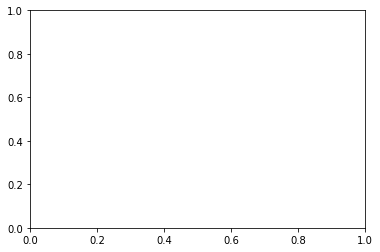

In [199]:
plot_decision_regions(X, y, clf=nb, legend=2)

In [201]:
svm.predict([[3.3 ,       1.0        ],
 [3.31299304, 1.        ],
 [3.32598608, 1.        ]])

array([0, 0, 0])

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


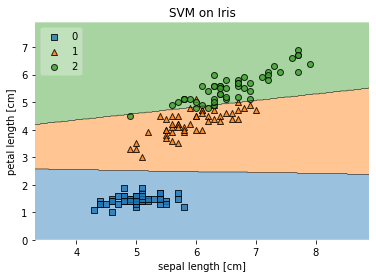

In [160]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

# Loading some example data
iris2 = datasets.load_iris()
X = iris2.data[:, [0, 2]]
y = iris2.target

# Training a classifier
svm = SVC(C=0.5, kernel='linear')
svm.fit(X, y)


# Plotting decision regions
plot_decision_regions(X, y, clf=svm, legend=2)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.title('SVM on Iris')
plt.show()

In [142]:
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target


In [144]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [143]:
X

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3],
       [4.6, 1.5],
       [5. , 1.4],
       [5.4, 1.7],
       [4.6, 1.4],
       [5. , 1.5],
       [4.4, 1.4],
       [4.9, 1.5],
       [5.4, 1.5],
       [4.8, 1.6],
       [4.8, 1.4],
       [4.3, 1.1],
       [5.8, 1.2],
       [5.7, 1.5],
       [5.4, 1.3],
       [5.1, 1.4],
       [5.7, 1.7],
       [5.1, 1.5],
       [5.4, 1.7],
       [5.1, 1.5],
       [4.6, 1. ],
       [5.1, 1.7],
       [4.8, 1.9],
       [5. , 1.6],
       [5. , 1.6],
       [5.2, 1.5],
       [5.2, 1.4],
       [4.7, 1.6],
       [4.8, 1.6],
       [5.4, 1.5],
       [5.2, 1.5],
       [5.5, 1.4],
       [4.9, 1.5],
       [5. , 1.2],
       [5.5, 1.3],
       [4.9, 1.4],
       [4.4, 1.3],
       [5.1, 1.5],
       [5. , 1.3],
       [4.5, 1.3],
       [4.4, 1.3],
       [5. , 1.6],
       [5.1, 1.9],
       [4.8, 1.4],
       [5.1, 1.6],
       [4.6, 1.4],
       [5.3, 1.5],
       [5. , 1.4],
       [7. , 4.7],
       [6.4, 4.5],
       [6.9,

In [123]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))



Number of mislabeled points out of a total 75 points : 4


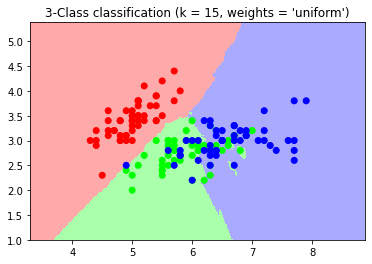

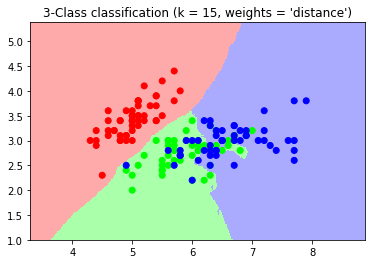

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris2 = datasets.load_iris()
X = iris2.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris2.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()